In [7]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

from GSSL import GSSLTransductive, GSSLInductive
from GSSL import gbili

from ucimlrepo import fetch_ucirepo

np.random.seed(42)

 # GBILI

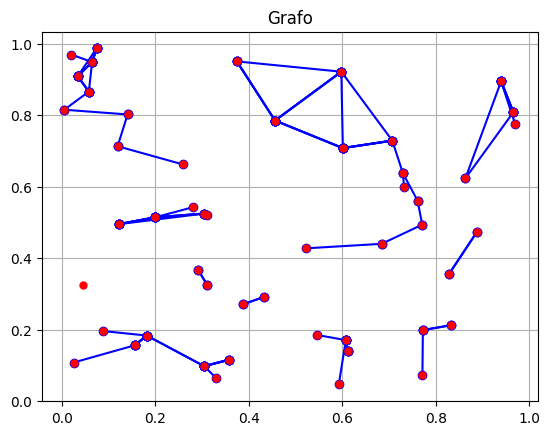

In [8]:
X = np.random.rand(50, 2)
y = np.random.choice([-1, 0, 1], size=50, p=[0.7, 0.15, 0.15])

V, E, W = gbili(X,y,3)

fig, ax = plt.subplots()

for a, b in E:
    ax.plot([X[a, 0], X[b, 0]], [X[a, 1], X[b, 1]], 'bo-')

ax.plot(X[:, 0], X[:, 1], 'ro', markersize=5)

ax.set_title('Grafo')
ax.grid(True)

plt.show()

In [9]:
fetch = fetch_ucirepo(id=186)

# Transductivo

In [10]:
dataset = fetch.data.features.values
real_targets = np.ravel(fetch.data.targets)
labels = np.copy(real_targets)

num_samples_to_unlabel = int(0.3 * len(labels))
unlabeled_indices = np.random.choice(len(labels), num_samples_to_unlabel, replace=False)
labels[unlabeled_indices] = -1

no_labeled = np.where(labels == -1)[0]
labeled = np.where(labels != -1)[0]

dataset_labeled = dataset[labeled, :]
labels_labeled = labels[labeled]

dataset_no_labeled = dataset[no_labeled, :]
labels_no_labeled = labels[no_labeled]

X = np.concatenate((dataset_labeled, dataset_no_labeled))
y = np.hstack((labels_labeled, labels_no_labeled))

trans = GSSLTransductive()

pred = trans.fit_predict(X, y)

print("Accuracy GSSL:", accuracy_score(real_targets[no_labeled], pred[len(labeled):]))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(dataset_labeled, labels_labeled)
print("Accuracy KNN:", accuracy_score(real_targets[no_labeled], knn.predict(dataset_no_labeled)))

Accuracy GSSL: 0.4787070292457671
Accuracy KNN: 0.46434068753206775


# Inductivo

In [8]:
dataset = fetch.data.features.values
real_targets = np.ravel(fetch.data.targets)
labels = np.copy(real_targets)

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.3, random_state=42)

num_samples_to_unlabel = int(0.7 * len(y_train))
unlabeled_indices = np.random.choice(len(y_train), num_samples_to_unlabel, replace=False)
y_train[unlabeled_indices] = -1

no_labeled = np.where(y_train == -1)[0]
labeled = np.where(y_train != -1)[0]

X_train_labeled = X_train[labeled, :]
y_train_labeled = y_train[labeled]

X_train_no_labeled = X_train[no_labeled, :]
y_train_no_labeled = y_train[no_labeled]

X = np.concatenate((X_train_labeled, X_train_no_labeled))
y = np.hstack((y_train_labeled, y_train_no_labeled))

trans = GSSLInductive()

trans.fit(X, y)

pred = trans.predict(X_test)

print("Accuracy GSSL:", accuracy_score(y_test, pred))
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_labeled, y_train_labeled)
print("Accuracy KNN:", accuracy_score(y_test, knn.predict(X_test)))

Accuracy GSSL: 0.4533333333333333
Accuracy KNN: 0.4451282051282051
